<a href="https://colab.research.google.com/github/K3dA2/Conditional-Diffusion-model/blob/main/cifar_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
! kaggle datasets download scribbless/another-anime-face-dataset

Dataset URL: https://www.kaggle.com/datasets/ayush1220/cifar10
License(s): copyright-authors
 95% 132M/139M [00:01<00:00, 86.6MB/s]
100% 139M/139M [00:01<00:00, 79.2MB/s]


In [3]:
!git clone https://github.com/K3dA2/Conditional-Diffusion-model.git

Cloning into 'Conditional-Diffusion-model'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 4), reused 16 (delta 3), pack-reused 0
Receiving objects: 100% (17/17), 8.38 KiB | 8.38 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
! unzip another-anime-face-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: cifar10/train/truck/0001.png  
  inflating: cifar10/train/truck/0002.png  
  inflating: cifar10/train/truck/0003.png  
  inflating: cifar10/train/truck/0004.png  
  inflating: cifar10/train/truck/0005.png  
  inflating: cifar10/train/truck/0006.png  
  inflating: cifar10/train/truck/0007.png  
  inflating: cifar10/train/truck/0008.png  
  inflating: cifar10/train/truck/0009.png  
  inflating: cifar10/train/truck/0010.png  
  inflating: cifar10/train/truck/0011.png  
  inflating: cifar10/train/truck/0012.png  
  inflating: cifar10/train/truck/0013.png  
  inflating: cifar10/train/truck/0014.png  
  inflating: cifar10/train/truck/0015.png  
  inflating: cifar10/train/truck/0016.png  
  inflating: cifar10/train/truck/0017.png  
  inflating: cifar10/train/truck/0018.png  
  inflating: cifar10/train/truck/0019.png  
  inflating: cifar10/train/truck/0020.png  
  inflating: cifar10/train/truck/0021.png  
  inflating: cifar10/trai

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import random
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, fname))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Return the image and a dummy label (e.g., 0)
        return image, 0

def get_data_loader(path, batch_size, num_samples=None, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.7002, 0.6099, 0.6036), (0.2195, 0.2234, 0.2097))
    ])

    full_dataset = CustomDataset(root_dir=path, transform=transform)

    if num_samples is None or num_samples > len(full_dataset):
        num_samples = len(full_dataset)
    print("data length:", len(full_dataset))

    if shuffle:
        indices = random.sample(range(len(full_dataset)), num_samples)
    else:
        indices = list(range(num_samples))

    subset_dataset = Subset(full_dataset, indices)

    data_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

    
path = '/content/animefaces256cleaner'
batch_size = 512
dataloader = get_data_loader(path, batch_size, num_samples=90_000, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import sys
sys.path.append('/content/Conditional-Diffusion-model')

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,Dataset
from PIL import Image
from tqdm import tqdm
import datetime
import os
import torch.nn.utils as utils
from model import UnetConditional,Unet,Config
from utils import forward_cosine_noise, reverse_diffusion_cfg, count_parameters,reverse_diffusion
import pandas as pd

using device: cuda


In [8]:
def training_loop(n_epochs, optimizer, model, loss_fn, device, data_loader, max_grad_norm=1.0, timesteps=200, epoch_start=0, accumulation_steps=4):
    model.train()
    for epoch in range(epoch_start, n_epochs + epoch_start):
        loss_train = 0.0

        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}', unit=' batch')
        optimizer.zero_grad()  # Initialize the gradient

        for batch_idx, (imgs, labels) in enumerate(progress_bar):
            imgs = imgs.to(device)
            labels = labels.to(device)
            # Generate timestamps
            t = torch.randint(0, timesteps, (imgs.size(0),), dtype=torch.float32).to(device) / timesteps
            t = t.view(-1, 1)

            imgs, noise = forward_cosine_noise(None, imgs, t, device= device)

            outputs = model(imgs, t)
            

            loss = loss_fn(outputs, noise)

            loss.backward()
            if (batch_idx + 1) % accumulation_steps == 0:
                utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            loss_train += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Save model checkpoint with the current epoch in the filename

        with open("cifar-diffusion-loss.txt", "a") as file:
            file.write(f"{loss_train / len(data_loader)}\n")

        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(data_loader)))
        # Save model checkpoint every 20 epochs
        if epoch % 20 == 0:
            model_filename = f'cifar-diffusion-cts_epoch_cfg.pth'
            model_path = os.path.join('/content/drive/MyDrive/Waifu Diffusion Model/', model_filename)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)

        # Optional: Generate samples every 5 epochs
        if epoch % 5 == 0:
            reverse_diffusion(model,50)


using device: cuda
param count:  67084164


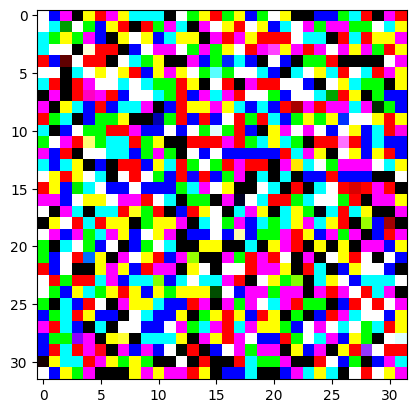

In [9]:
timesteps = 1000

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")
config = Config()
model = Unet(config)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
loss_fn = nn.MSELoss().to(device)
print("param count: ", count_parameters(model))


reverse_diffusion(model,50)


In [10]:
training_loop(
    n_epochs=1000,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    device=device,
    data_loader=dataloader,
    timesteps=timesteps,
    epoch_start=0,
    accumulation_steps=4  # Adjust this value as needed
)

Epoch 0:   0%|          | 0/313 [00:00<?, ? batch/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch 0: 100%|██████████| 313/313 [00:29<00:00, 10.73 batch/s, loss=0.99]

2024-07-04 08:25:14.281277 Epoch 0, Training loss 0.9999171807743109


RuntimeError: Parent directory /Users/ayanfe/Documents/Code/Diffusion-Model/weights does not exist.